## Check performance of repeated Bus Time API calls
We observed that a the API response sometimes came after an extended delay.  This checks the frequency of the API response time stamps throughout all data collected.

In [1]:
import os
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

#### Import desciptive metadata
Each stored JSON was <a href='https://github.com/sarangof/Bus-Capstone/blob/master/jsons_response_sizes.py'>parsed to extract a few basic properties</a>:
1. ResponseTimestamp
2. Count of VehicleLocation objects
3. Number of characters in file between first and last VehicleActivity object
4. Name of file as stored on our server (since previously, two API calls were required to collect from separate agencies)

In [2]:
data = pd.read_csv('jsons_summary.csv',index_col=0)
data.head(20)

,response_time_stamp,veh_count,veh_str_len,filename
0,2015-11-01T23:59:46.108-05:00,573,5118969,2015_11_02_nyct
1,2015-11-02T00:00:52.900-05:00,572,5125493,2015_11_02_nyct
2,2015-11-02T00:01:57.458-05:00,574,5115853,2015_11_02_nyct
3,2015-11-02T00:03:01.498-05:00,580,5210647,2015_11_02_nyct
4,2015-11-02T00:04:27.375-05:00,570,5054389,2015_11_02_nyct
5,2015-11-02T00:05:35.451-05:00,564,5069069,2015_11_02_nyct
6,2015-11-02T00:06:39.570-05:00,563,4995810,2015_11_02_nyct
7,2015-11-02T00:07:44.925-05:00,561,4896862,2015_11_02_nyct
8,2015-11-02T00:09:04.444-05:00,559,4886586,2015_11_02_nyct
9,2015-11-02T00:10:07.946-05:00,553,4828978,2015_11_02_nyct


Parse the response time strings to get some grouping-friendly elements.

In [3]:
data['source'] = data.filename.str[11:]
data['hour'] = data.response_time_stamp.str[11:13]
data['response_date'] = data['response_time_stamp'].str[:10]
data.sort(['source','response_time_stamp'],inplace=True)
data.reset_index(drop=True,inplace=True)
data['response_time_stamp'] = pd.to_datetime(data.response_time_stamp)
# also calculate the difference from one to the next
data['elapsed'] = data['response_time_stamp'].diff()/timedelta(seconds=1)
data['weekday'] = data['response_time_stamp'].apply(datetime.weekday)

Check the distribution of time deltas.

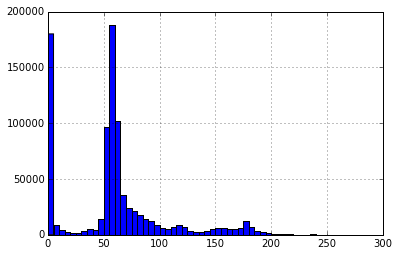

In [4]:
data['elapsed'].hist(range=(0,300),bins=60)

Check for extremes: how many gaps were longer than 5 minutes?  5-minute gaps aren't so problematic since the median trip duration is about 45 minutes.

In [5]:
sum(data['elapsed']>300)

2868

Longer than 30 minutes?  Those are problematic because entire trips will be missed, or only a few stops can be interpolated from it.

In [6]:
sum(data['elapsed']>1800)

606

That's still a large number.  Are those gaps repeating throughout the year?

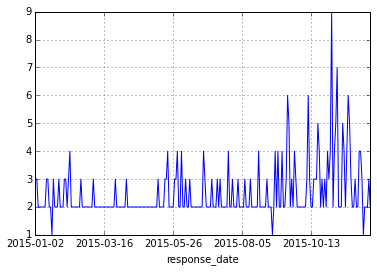

In [7]:
data.query('elapsed > 1800').groupby('response_date').size().plot()

Do those 30-minute gaps happen on certain weekdays?

In [8]:
data.query('elapsed > 1800').groupby('weekday').size()

weekday
0    100
1    113
2    119
3    109
4    124
5     20
6     21
dtype: int64

It's much more prevalent on business days.  Is the problem clustered around certain time of day?

In [9]:
data.query('elapsed > 1800 & weekday <= 5').groupby('hour').size()

hour
00      2
01      1
02      6
03      2
04     10
05      4
06      2
07      8
08     58
09    169
10      8
11      4
12      4
13      4
14     13
15     16
16     11
17      9
18    112
19    126
20      6
21      2
22      6
23      2
dtype: int64

In [10]:
data[data['response_date']=='2015-11-05'].groupby('hour').size()

hour
00    106
01    125
02    137
03    140
04    127
05     90
06     37
07     20
08     20
09     31
10     43
11     33
12     26
13     23
14     23
15     22
16     19
17     17
18      1
19     12
20     15
21     60
22     87
23     98
dtype: int64

In [11]:
gaps_by_date = data.query('elapsed > 1800').groupby('response_date').size()

In [12]:
gaps_by_date.sort()

In [13]:
gaps_by_date[:5]

response_date
2015-09-03    1
2015-11-27    1
2015-01-19    1
2015-07-08    2
2015-07-10    2
dtype: int64

In [14]:
gaps_by_date[-15:]

response_date
2015-07-22    4
2015-02-06    4
2015-08-21    4
2015-11-11    4
2015-10-30    4
2015-10-20    5
2015-09-21    5
2015-11-10    5
2015-11-04    5
2015-11-16    5
2015-09-20    6
2015-11-14    6
2015-10-09    6
2015-11-05    7
2015-11-01    9
dtype: int64

### Try to find a string of seven days NO 30+ minutes gaps

In [54]:
for d in data.response_date.unique():
    if d in list(gaps_by_date.index):
        pass
    else:
        print d

2015-01-01
2015-01-03
2015-01-04
2015-01-10
2015-01-11
2015-01-17
2015-01-24
2015-01-25
2015-01-27
2015-01-31
2015-02-01
2015-02-07
2015-02-08
2015-02-14
2015-02-15
2015-02-16
2015-02-21
2015-02-22
2015-02-28
2015-03-01
2015-03-07
2015-03-08
2015-03-14
2015-03-15
2015-03-21
2015-03-22
2015-03-28
2015-03-29
2015-04-04
2015-04-05
2015-04-11
2015-04-12
2015-04-18
2015-04-19
2015-04-25
2015-04-26
2015-05-02
2015-05-03
2015-05-09
2015-05-10
2015-05-16
2015-05-17
2015-05-23
2015-05-24
2015-05-25
2015-05-30
2015-05-31
2015-06-06
2015-06-07
2015-06-13
2015-06-14
2015-06-20
2015-06-27
2015-06-28
2015-07-03
2015-07-04
2015-07-05
2015-07-11
2015-07-18
2015-07-19
2015-07-25
2015-07-26
2015-08-01
2015-08-02
2015-08-08
2015-08-09
2015-08-15
2015-08-16
2015-08-23
2015-08-29
2015-08-30
2015-09-05
2015-09-06
2015-09-07
2015-09-12
2015-09-13
2015-09-19
2015-09-26
2015-09-27
2015-10-03
2015-10-04
2015-10-10
2015-10-17
2015-10-18
2015-10-25
2015-10-31
2015-11-08
2015-11-15
2015-11-26
2015-11-28
2015-12-01

In [55]:
data.query('response_date >= "2015-12-01" & response_date <= "2015-12-07" & elapsed > 1800').sort('response_date')

,response_time_stamp,veh_count,veh_str_len,filename,source,hour,response_date,elapsed,weekday
485167,2015-12-06 08:00:02.713000,36,249523,2015_12_06_bc,bc,03,2015-12-06,13331.976,6
854060,2015-12-06 08:00:03.263000,154,1433557,2015_12_06_nyct,nyct,03,2015-12-06,13388.250,6


In [59]:
data.groupby('response_date').size().iloc[-20:]

response_date
2015-11-20    1233
2015-11-21    1792
2015-11-22    1914
2015-11-23    1339
2015-11-24    1448
2015-11-25    1250
2015-11-26    2073
2015-11-27    1579
2015-11-28    1784
2015-11-29    1950
2015-11-30    1405
2015-12-01    2086
2015-12-02    2014
2015-12-03    2033
2015-12-04    2065
2015-12-05    2341
2015-12-06    2206
2015-12-07    2059
2015-12-08    1806
2015-12-30     295
dtype: int64